# Merge WikiData and Reactome into a Single Hetnet

## Potential Issues

1. Lots of Reactome Concepts from species we don't care about
    1. Find the Infectious Taxa definied by WikiData
    2. Filter so only homo sapiens and infectious taxa items remain.
2. Wiki has its own internal identifiers (Q#########) That interface with nothing Else.
    3. some have one to many relationships to external identifiers....
    1. Pick an external Identifer for each Concept type (`label`)
        2. Or a priority order
    2. map Wiki to these identifiers
    3. Items with no Xref will retain an WikiData Identifier (with `WD` CURI).
    4. Reactome will be mapped to these IDs
1. Reactome has Genes split into multiple nodes (Ensembl, Entrez, Uniprot).
    1. Mapping External IDs to WikiData Xrefs will allow us to merge most of these concepts
    2. Reactome Internal IDs can ponteially be leveraged for merging
    1. mygene.info is also an authoritative source that can be used to Resolve
3. Reactome Nodes have bad `name`s
    1. Take WikiData names first on those that can be mapped 
    3. mygene.info and mychem.info can get proper identifier to name values for those unmapped.


In [1]:
%matplotlib inline
import pandas as pd
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
from data_tools import wiki as wiki
from data_tools import df_processing as dfp
from data_tools.plotting import count_plot_h
from data_tools.files import load_api_results
from data_tools import combine_nodes_and_edges

In [2]:
wiki_dir = Path('../2_pipeline/01d_WikiData_Compute/out/').resolve()
react_dir = Path('../2_pipeline/02b_Reactome_Process_Queries/out/').resolve()

wiki_nodes = pd.read_csv(wiki_dir.joinpath('nodes.csv'))
wiki_edges = pd.read_csv(wiki_dir.joinpath('edges.csv'), dtype=str)

react_nodes = pd.read_csv(react_dir.joinpath('nodes.csv'), dtype=str)
react_edges = pd.read_csv(react_dir.joinpath('edges.csv'), dtype=str)

In [3]:
nb_name = '03_WikiData_Reactome_Merge'
out_dir = Path('../2_pipeline/').joinpath(nb_name, 'out').resolve()

# Make the output directory if doesn't already exist
out_dir.mkdir(parents=True, exist_ok=True)

In [4]:
wiki_edges.head()

,start_id,end_id,type,dsrc_type,comp_type,p_val,adj_p,source,license
0,Q311109,Q16333787,causes,crowd_sourced,NaN,NaN,NaN,WikiData,CC0 1.0
1,Q3933465,Q18975593,causes,crowd_sourced,NaN,NaN,NaN,WikiData,CC0 1.0
2,Q5161050,Q5161045,causes,crowd_sourced,NaN,NaN,NaN,WikiData,CC0 1.0
3,Q1883623,Q19000538,causes,crowd_sourced,NaN,NaN,NaN,WikiData,CC0 1.0
4,Q12270752,Q18553237,causes,crowd_sourced,NaN,NaN,NaN,WikiData,CC0 1.0


In [5]:
react_nodes.query('label == "Taxon"')

,id,name,label,xrefs
425560,NCBITaxon:9606,Homo sapiens,Taxon,NaN
425561,NCBITaxon:10116,Rattus norvegicus,Taxon,NaN
425562,NCBITaxon:9615,Canis familiaris,Taxon,NaN
425563,NCBITaxon:4896,Schizosaccharomyces pombe,Taxon,NaN
425564,NCBITaxon:4932,Saccharomyces cerevisiae,Taxon,NaN
...,...,...,...,...
425626,NCBITaxon:12637,Dengue virus,Taxon,NaN
425627,NCBITaxon:11034,Sindbis virus,Taxon,NaN
425628,NCBITaxon:28875,Rotavirus A,Taxon,NaN
425629,NCBITaxon:11191,Sendai virus,Taxon,NaN


# Reactome to External (Revisited)

Some reacome items have multiple xrefs... some xrefs have multiple reactome items... To resolve this we will use Reactome IDs to group xrefs, so we have 1 xref per reactome ID. Then if there are multiple IDs from the same xref source (e.g. 3 NCBIGene IDs for 1 reactome ID) we will split into that number of nodes.

The first step in this is we need xrefs grouped by Reactome ID

In [6]:
# Split those with multi xrefs
react_xrefs = dfp.expand_col_on_char(react_nodes.dropna(subset=['xrefs']), 'xrefs', '|')
react_xrefs = react_xrefs[['id', 'xrefs']]
# Make the external IDs the xref, and the Reactome IDs id 
# (this will be useful for later CURI selection)
react_xrefs.columns = ['xrefs', 'id']
react_xrefs.sample(10, random_state=13905)

,xrefs,id
243632,UniProt:F1RIV4,REACT:R-SSC-6807446
372448,UniProt:Q8IQ70,REACT:R-DME-8949153
62051,NCBIGene:286995,REACT:R-RNO-1471358-8
463260,ENSG:ENSDARG00000089952,REACT:R-DRE-5625341
359226,UniProt:Q6GMG0,REACT:R-DRE-1236895-20
20085,NCBIGene:12825,REACT:R-MMU-2468096
362254,UniProt:Q6W4X9,REACT:R-HSA-1462338
342344,UniProt:Q3UTH8,REACT:R-MMU-195067
305060,UniProt:P20000,REACT:R-BTA-71718
574981,ENSG:ENSSSCG00000009092,REACT:R-SSC-426172


In [7]:
# Group by the Xrefs
grpd_react_xrefs = dfp.combine_group_cols_on_char(react_xrefs, 'id', ['xrefs'], sort=True, prog=False)
grpd_react_xrefs.sample(10, random_state=14753)

,xrefs,id
157320,ENSG:ENSMUSG00000042219|NCBIGene:258961|UniPro...,REACT:R-MMU-378824
95253,ENSG:ENSDARG00000070387|NCBIGene:100329471|Uni...,REACT:R-DRE-6809215
156326,ENSG:ENSMUSG00000037246|NCBIGene:224761|UniPro...,REACT:R-MMU-3318262-25
69819,ENSG:FBgn0040068|NCBIGene:32920|UniProt:Q9NHV9,REACT:R-DME-442287
36585,ENSG:WBGene00013746|NCBIGene:180312|UniProt:G5...,REACT:R-CEL-975392-7
24945,ENSG:WBGene00003169|NCBIGene:181678|UniProt:G5...,REACT:R-CEL-2023659
17213,ENSG:ENSBTAG00000007362|UniProt:E1BDJ1,REACT:R-BTA-67441
79329,ENSG:ENSDARG00000070109|NCBIGene:492707|UniPro...,REACT:R-DRE-1638136
6099,ENSG:ENSBTAG00000013353|NCBIGene:534170|UniPro...,REACT:R-BTA-1027416
75689,ENSG:FBgn0031452|NCBIGene:33460|UniProt:Q9VQF5,REACT:R-DME-8867898


## Clearing Extraneous Taxa

In [8]:
tax_xrefs = wiki.get_curi_xrefs(wiki_nodes.query('label == "Taxon"'), 'NCBITaxon')
keep_tax_ids = tax_xrefs['xrefs'].unique().tolist()

# Keep human IDs
keep_tax_ids.append('NCBITaxon:9606')

### Examine the Taxa that will be dropped from Reactome...

In [9]:
react_nodes.query('label == "Taxon" and id not in @keep_tax_ids')

,id,name,label,xrefs
425561,NCBITaxon:10116,Rattus norvegicus,Taxon,NaN
425562,NCBITaxon:9615,Canis familiaris,Taxon,NaN
425563,NCBITaxon:4896,Schizosaccharomyces pombe,Taxon,NaN
425564,NCBITaxon:4932,Saccharomyces cerevisiae,Taxon,NaN
425565,NCBITaxon:44689,Dictyostelium discoideum,Taxon,NaN
425566,NCBITaxon:8364,Xenopus tropicalis,Taxon,NaN
425567,NCBITaxon:7955,Danio rerio,Taxon,NaN
425569,NCBITaxon:10090,Mus musculus,Taxon,NaN
425570,NCBITaxon:9031,Gallus gallus,Taxon,NaN
425571,NCBITaxon:9913,Bos taurus,Taxon,NaN


## Drop all nodes in that taxa

In [10]:
drop_nodes = react_edges.query('type == "in_taxon" and end_id not in @keep_tax_ids')['start_id'].unique()

In [11]:
drop_edge_idx = react_edges.query('start_id in @drop_nodes or end_id in @drop_nodes').index
react_edges = react_edges.drop(drop_edge_idx).reset_index(drop=True)

In [12]:
react_nodes = react_nodes.query('id not in @drop_nodes').reset_index(drop=True)

In [13]:
print('Nodes: {:,}\nEdges: {:,}'.format(len(react_nodes), len(react_edges)))

Nodes: 87,718
Edges: 1,572,980


## Combining the sources

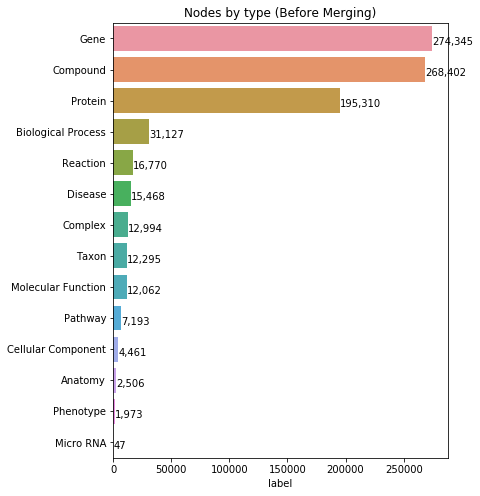

In [14]:
plt.figure(figsize=(6, 8))
count_plot_h(pd.concat([wiki_nodes, react_nodes], sort=False)['label'].value_counts())
plt.title('Nodes by type (Before Merging)');

In [15]:
label_to_curi = {'Gene': ['NCBIGene', 'ENSG', 'HGNC', 'SYM', 'UniProt',  'OMIM'],
    # Uniprot covers everything
    'Protein': ['UniProt'], 
    # CHEBI First as Reactome is 100% CHBEI, then Other Gvt IDs, and Public, finsh with less open IDs
    'Compound': ['CHEBI', 'CHEMBL', 'UNII', 'DB', 'PCID', 'RXCUI', 'IKEY', 'MESH', 'KEGG', 'UMLS'], 
            
    'Reaction': ['REACT'], 
    'Complex': ['REACT'], 
    'Biological Process': ['GO'], 
    'Pathway': ['REACT', 'WP'], 
    # STart with DO, reactome also uses DO
    'Disease': ['DOID', 'MONDO', 'MESH', 'UMLS', 'SNOMED', 'OMIM'], 
    'Taxon': ['NCBITaxon'], 
    'Molecular Function': ['GO'], 
    'Cellular Component': ['GO'], 
    'Anatomy': ['UBERON'], 
    'Phenotype': ['HP', 'MESH', 'OMIM', 'SNOMED'], 
    'Micro RNA': ['MI']}

In [16]:
def get_curis(series):
    return series.apply(lambda c: c.split(':')[0])

def get_unique_curis(series):
    return set(get_curis(series))

In [17]:
import re

def is_wd_id(_id):
    """Wikidata IDs start with Q then a variable length of numbers"""
    wd_regex = re.compile('Q[0-9]+')
    m = wd_regex.match(_id)
    return bool(m) and (m.start() == 0 and m.end() == len(_id))

In [18]:
def nodes_to_curi_xrefs(nodes, label, curis):
    """
    Query nodes of a certain label for xrefs of certain CURIs. 
    A list of CURIs will determine preferrential order for definitive xrefs.
    """
    found_ids = set()
    curi_map = []

    for curi in curis:
        qr = nodes.query('id not in @found_ids and label == @label').dropna(subset=['xrefs'])

        # All ids might be found before all curis queried
        if len(qr) > 0:
            this_map = wiki.get_curi_xrefs(qr, curi)
            found_ids = set(this_map['id']).union(found_ids)

            curi_map.append(this_map)

    # one final query for items with no Xref
    qr = nodes.query('id not in @found_ids and label == @label')[['id', 'xrefs']].copy()
    
    wd_ids = qr['id'].apply(is_wd_id)
    wd_idx = qr[wd_ids].index
    not_wd_idx = qr[~wd_ids].index
    
    # Preppend a WikiData CUI onto wikidata Identifiers
    qr.loc[wd_idx, 'xrefs'] = 'WD:'+qr.loc[wd_idx, 'id']
    qr.loc[not_wd_idx, 'xrefs'] = qr.loc[not_wd_idx, 'id']
    
    curi_map.append(qr)

    curi_map = pd.concat(curi_map, sort=False, ignore_index=True)
    return curi_map

In [19]:
reactome_curis = get_curis(react_nodes['id'])

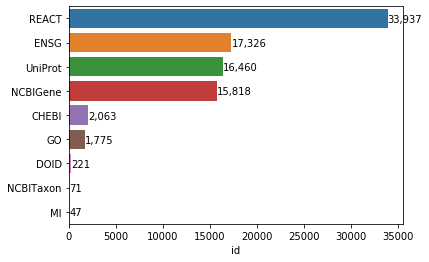

In [20]:
count_plot_h(reactome_curis)

In [21]:
curi_map = nodes_to_curi_xrefs(wiki_nodes, 'Gene', ['NCBIGene', 'ENSG', 'HGNC', 'SYM', 'UniProt',  'OMIM'])

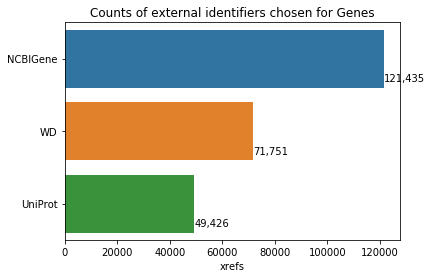

In [22]:
count_plot_h(get_curis(curi_map['xrefs']).value_counts())
plt.title('Counts of external identifiers chosen for Genes');

In [23]:
def curi_map_to_final_map(curi_map, nodes):
    """
    Takes a 2-col mapping Dataframe from original ID to Xref ID
    Maps all other potential Xrefs to the definitive Final ID in the original dataframe
    """

    out_map = curi_map.rename(columns={'xrefs': 'final_id'})
    
    node_ids = out_map['id'].unique().tolist()
    
    node_to_xref = dfp.expand_col_on_char(nodes.query('id in @node_ids'), 'xrefs', '|', True)[['id', 'xrefs']]
    if len(node_to_xref) > 0:
        map_to_xref = node_to_xref.merge(out_map, how='left', on='id').drop('id', axis=1)
    
        return map_to_xref
    else:
        return None

In [24]:
def find_react_keep_ids(wd_map, label):

    if wd_map is not None:
        xref_ids = wd_map['xrefs'].unique()
        wd_final_ids = set(wd_map['final_id'])
    else:
        xref_ids = []
        wd_final_ids = set()

    react_nt_nodes = react_nodes.query('label == @label')
    nt_ids = react_nt_nodes['id'].unique()

    # Items that are reacome specific should all be kept
    if 'REACT' in label_to_curi[label]:
        return set(nt_ids)
    
    # Reactome nodes of current Node-Label NOT mappable to WikiData
    need_consolidate = react_xrefs.query('xrefs in @nt_ids and xrefs not in @xref_ids')
    nc_ids = need_consolidate['id'].unique()

    need_consolidate = grpd_react_xrefs.query('id in @nc_ids').copy()
    need_consolidate['label'] = label

    react_map = nodes_to_curi_xrefs(need_consolidate, label, label_to_curi[label])

    react_keep_ids = set(react_map['xrefs']) | wd_final_ids

    return react_keep_ids

We will lose the Xrefs between different external sources to Reactome, but they can always be recalled (liekly with better accuracy) form a source like mygene

Wiki edges need to be mapped to external IDs.

Reactome edges are already in external IDs so they just need to be filtered to the IDs we're going to keep. (we will do an all at once filter at the very end).

In [25]:
wiki_curi_maps = dict()
react_to_wd_map = []
wd_to_final_map = []
all_keep_react_ids = set()

for label, curi_list in label_to_curi.items():
    curi_map = nodes_to_curi_xrefs(wiki_nodes, label, curi_list)
    wd_map = curi_map_to_final_map(curi_map, wiki_nodes)
    keep_react_ids = find_react_keep_ids(wd_map, label)
    
    wiki_curi_maps[label] = curi_map
    all_keep_react_ids = all_keep_react_ids.union(keep_react_ids)
    wd_to_final_map.append(curi_map)
    react_to_wd_map.append(wd_map)

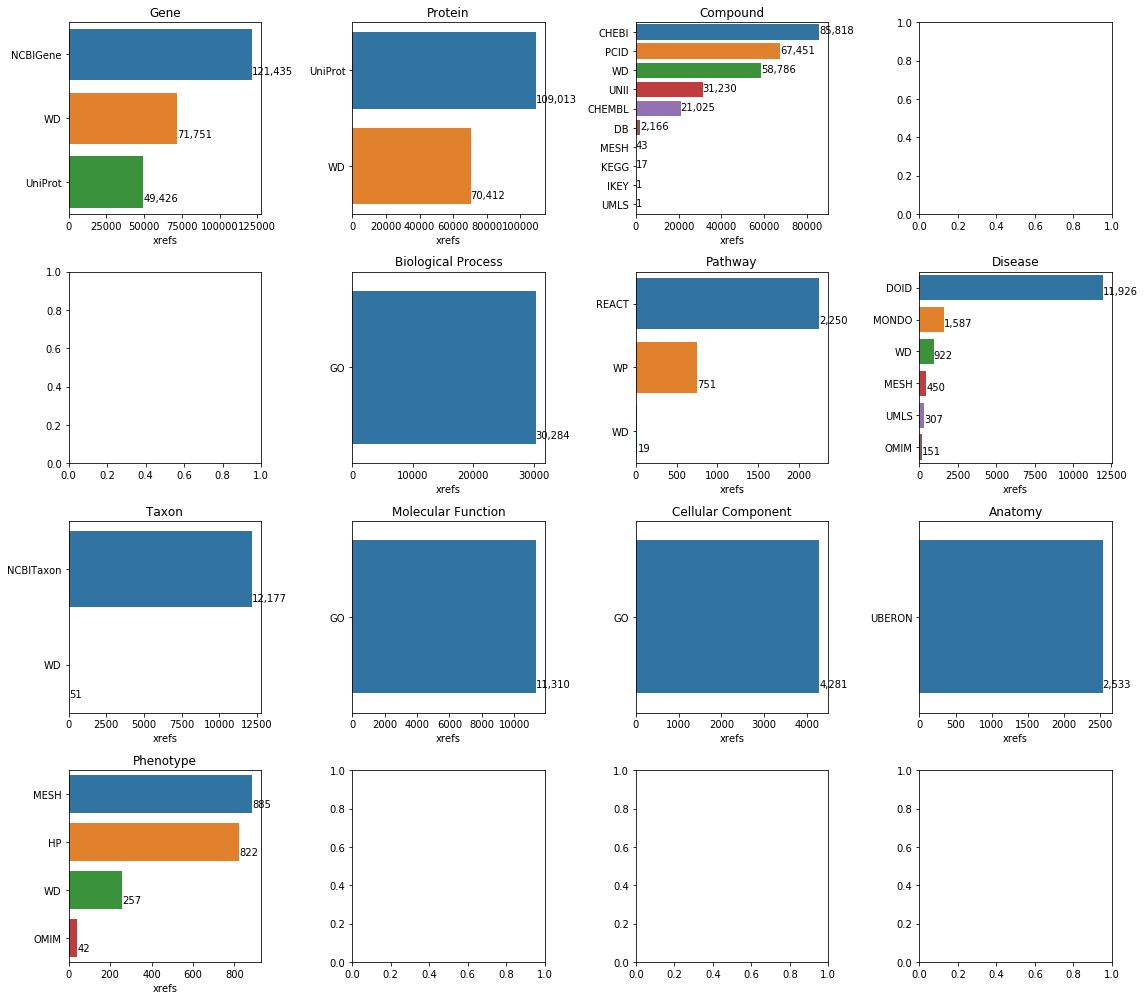

In [26]:
fig, ax = plt.subplots(4, 4, figsize=(16, 14))


for i, (label, mapper) in enumerate(wiki_curi_maps.items()):
    row = i // 4
    col = i % 4
    
    if len(mapper) > 0:
        count_plot_h(get_curis(mapper['xrefs']), ax=ax[row][col])
        ax[row][col].set_title(label)
fig.tight_layout()    

In [27]:
gbo = react_nodes.query('id in @all_keep_react_ids').groupby('label')
react_keepers = {k: react_nodes.loc[v, 'id'] for k, v in gbo.groups.items()}

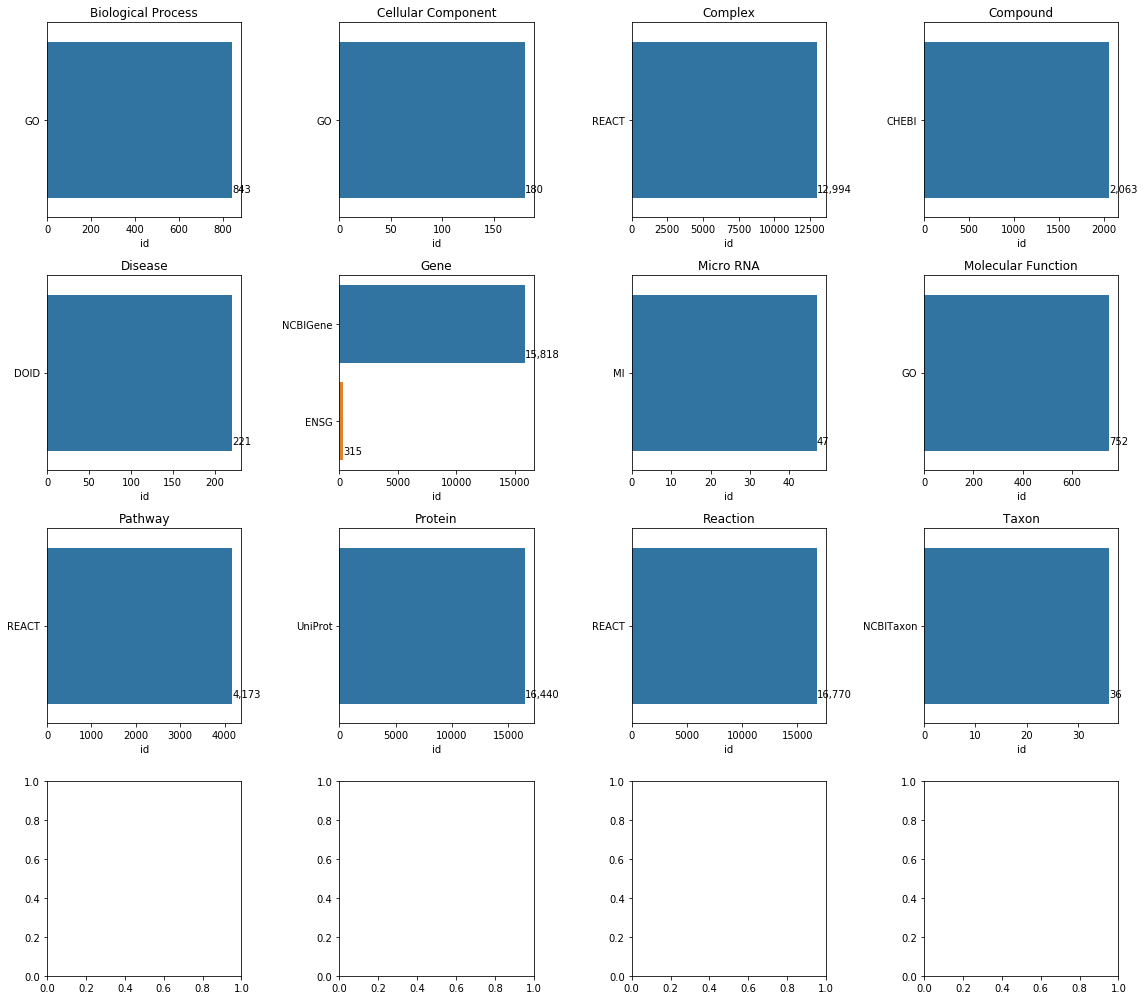

In [28]:
fig, ax = plt.subplots(4, 4, figsize=(16, 14))


for i, (label, mapper) in enumerate(react_keepers.items()):
    row = i // 4
    col = i % 4
    
    if len(mapper) > 0:
        count_plot_h(get_curis(mapper), ax=ax[row][col])
        ax[row][col].set_title(label)
fig.tight_layout()    

In [29]:
react_to_wd_map = pd.concat(react_to_wd_map, sort=False, ignore_index=True)
wd_to_final_map = pd.concat(wd_to_final_map, sort=False, ignore_index=True)

In [30]:
react_to_wd_map.head(2)

,xrefs,final_id
0,UniProt:Q4DJR6,UniProt:Q4DJR6
1,UniProt:Q4DJR5,UniProt:Q4DJR5


Only keep the Reactome nodes who are not in the wikidata nodes...

In [31]:
react_nodes_filt = react_nodes.query('id in @all_keep_react_ids').copy()

Now merge Reactome to WikiData Xrefs on the edges.

Then we will filter based on all the final identifiers

In [32]:
def map_edge_ids(edges, id_mapper, old_id_col, new_id_col):
    edge_col_order = edges.columns
    edge_mrg = edges.merge(id_mapper.rename(columns={old_id_col: 'start_id', new_id_col: 'new_start_id'}), how='left', on='start_id')
    edge_mrg['new_start_id'] = edge_mrg['new_start_id'].fillna(edge_mrg['start_id'])
    edge_mrg = edge_mrg.drop('start_id', axis=1).rename(columns={'new_start_id': 'start_id'})
    
    edge_mrg = edge_mrg.merge(id_mapper.rename(columns={old_id_col: 'end_id', new_id_col: 'new_end_id'}), how='left', on='end_id')
    edge_mrg['new_end_id'] = edge_mrg['new_end_id'].fillna(edge_mrg['end_id'])
    edge_mrg = edge_mrg.drop('end_id', axis=1).rename(columns={'new_end_id': 'end_id'})
    
    return edge_mrg.drop_duplicates(subset=['start_id', 'end_id', 'type'])[edge_col_order].reset_index(drop=True)

In [33]:
all_final_ids = all_keep_react_ids | set(wd_to_final_map['xrefs'])

react_edges_mapped = map_edge_ids(react_edges, react_to_wd_map, 'xrefs', 'final_id')
react_edges_filt = react_edges_mapped.query('start_id in @all_final_ids and end_id in @all_final_ids').copy()
len(react_edges_filt)

1370026

In [34]:
len(react_nodes_filt)

70652

In [35]:
len(react_nodes)

87718

In [36]:
len(react_edges)

1572980

Fix names with Mygene

In [37]:
from biothings_client import get_client

In [38]:
mg = get_client('gene')

In [39]:
react_nodes_filt['base_id'] = react_nodes_filt['id'].apply(lambda g: g.split(':')[-1])
gene_ids = react_nodes_filt.query('label == "Gene"')['base_id'].tolist()

In [40]:
gn = load_api_results(out_dir.joinpath('mg_gene_info_{}.pkl'), False, mg.getgenes, 
                      ids=gene_ids, fields=['name'])

In [41]:
name_map = {n['query']: n.get('name') for n in gn}

In [42]:
prot_ids = react_nodes_filt.query('label == "Protein"')['base_id'].tolist()

In [43]:
pn = load_api_results(out_dir.joinpath('mg_prot_info_{}.pkl'), False, mg.querymany, 
                      qterms=prot_ids, scopes='uniprot')

In [44]:
name_map = {**{n['query']: n.get('name') for n in pn}, **name_map}

In [45]:
react_nodes_filt['name'] = react_nodes_filt['base_id'].map(name_map).fillna(react_nodes_filt['name'])
react_nodes_filt = react_nodes_filt.drop('base_id', axis=1)

In [46]:
wiki_reid = wiki_nodes.merge(wd_to_final_map.rename(columns={'xrefs': 'final_id'}), on='id', how='left')

In [47]:
wiki_reid.head(2)

,id,name,label,xrefs,final_id
0,Q1010102,Bunyaviridae,Taxon,NaN,WD:Q1010102
1,Q1026758,Caliciviridae,Taxon,NCBITaxon:11974,NCBITaxon:11974


Some ids should be duplicated as we've designed this to merge some items.  Let's just check them

In [48]:
wiki_reid['final_id'].duplicated(keep=False).sum()

99757

Almost 100,000 duplications

Look at what things are grouped together...

In [49]:
wiki_reid[wiki_reid['final_id'].duplicated(keep=False)].groupby('final_id')['label'].apply(lambda r: ', '.join(sorted(set(r)))).value_counts()

Gene, Protein         48724
Compound                120
Disease                  96
Protein                  66
Anatomy                  51
Phenotype                42
Pathway                   9
Disease, Phenotype        2
Taxon                     1
Name: label, dtype: int64

Most are of the same type, so just merge the corss-references and drop.  However, need to check genes and proteins... I'm thinking those are ones from infectious taxa where we only had a UniProt ID as an x-ref. Let's confirm this and set all to Proteins

In [50]:
labels = ['Gene', 'Protein']
dup_gene_prot = wiki_reid[wiki_reid['final_id'].duplicated(keep=False)].query('label in @labels')
dup_gene_prot['final_id'].apply(lambda s: s.split(':')[0]).unique()

array(['UniProt'], dtype=object)

In [51]:
wiki_reid = dfp.combine_group_cols_on_char(wiki_reid, ['final_id'], ['xrefs'], sort=True, prog=False)

In [52]:
len(wiki_nodes), len(wiki_reid)

(767235, 718934)

In [53]:
wiki_reid = wiki_reid.drop(['id'], axis=1).rename(columns={'final_id': 'id'})

In [54]:
wiki_reid.head(2)

,name,label,xrefs,id
0,Bunyaviridae,Taxon,NaN,WD:Q1010102
1,Caliciviridae,Taxon,NCBITaxon:11974,NCBITaxon:11974


In [55]:
all_nodes = pd.concat([wiki_reid, react_nodes_filt], sort=False, ignore_index=True)[['id', 'name', 'label', 'xrefs']]

In [56]:
all_nodes['id'].duplicated(keep=False).sum()

69574

More duplications to fix

In [57]:
all_nodes[all_nodes['id'].duplicated(keep=False)].groupby('id')['label'].apply(lambda r: ', '.join(sorted(set(r)))).value_counts()

Gene                  14780
Protein               14178
Pathway                2205
Compound               1592
Biological Process      843
Molecular Function      752
Disease                 221
Cellular Component      180
Taxon                    36
Name: label, dtype: int64

Just combine the Xrefs...

In [58]:
all_nodes = dfp.combine_group_cols_on_char(all_nodes, ['id'], ['xrefs'], sort=True, prog=False)

In [59]:
len(all_nodes)

754799

In [60]:
wiki_edges_mapped = map_edge_ids(wiki_edges, wd_to_final_map, 'id', 'xrefs')
wiki_edges_mapped = wiki_edges_mapped

## Merge the remaing edges and drop nodes not represented in edges

In [61]:
def combine_info_to_remove_dups(edges):
    duped = edges.duplicated(subset=['start_id', 'type', 'end_id'], keep=False)
    
    single_edges = edges[~duped].copy()
    duped_edges = edges[duped].copy()
    
    fixed_dups = dfp.combine_group_cols_on_char(duped_edges, ['start_id', 'end_id', 'type'], sort=True, prog=False)
    return pd.concat([single_edges, fixed_dups], sort=False, ignore_index=True)
    

In [62]:
all_edges = pd.concat([wiki_edges_mapped, react_edges_filt], sort=False, ignore_index=True)
print(len(all_edges))

2608370


In [63]:
all_edges.head(2)

,start_id,end_id,type,dsrc_type,comp_type,p_val,adj_p,source,license
0,NCBITaxon:6293,DOID:12210,causes,crowd_sourced,NaN,NaN,NaN,WikiData,CC0 1.0
1,NCBITaxon:186938,DOID:3729,causes,crowd_sourced,NaN,NaN,NaN,WikiData,CC0 1.0


In [64]:
all_edges = combine_info_to_remove_dups(all_edges)
print(len(all_edges))

2571504


In [65]:
all_edge_ids = set(all_edges['start_id']).union(set(all_edges['end_id']))

In [66]:
len(all_edge_ids)

323547

In [67]:
nodes_filt = all_nodes.query('id in @all_edge_ids')
len(nodes_filt)

323547

In [68]:
filt_node_ids = set(nodes_filt['id'])

In [69]:
combo = combine_nodes_and_edges(nodes_filt, all_edges)

In [70]:
qr = combo.query('start_label == "Gene" or end_label == "Gene"')

In [71]:
me = qr['start_label'] + ' - ' + qr['type'] + ' - ' + qr['end_label']

In [72]:
me.nunique()

24

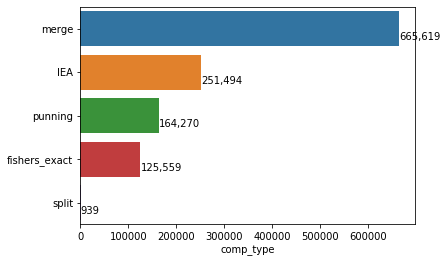

In [73]:
count_plot_h(all_edges['comp_type'])

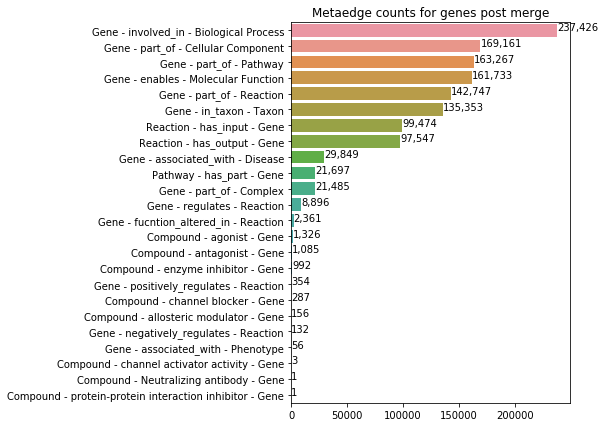

In [74]:
plt.figure(figsize=(5, 7))
count_plot_h(me.value_counts())
plt.title('Metaedge counts for genes post merge');

In [75]:
me = combo['start_label'] + ' - ' + combo['type'] + ' - ' + combo['end_label']

In [76]:
me.nunique()

87

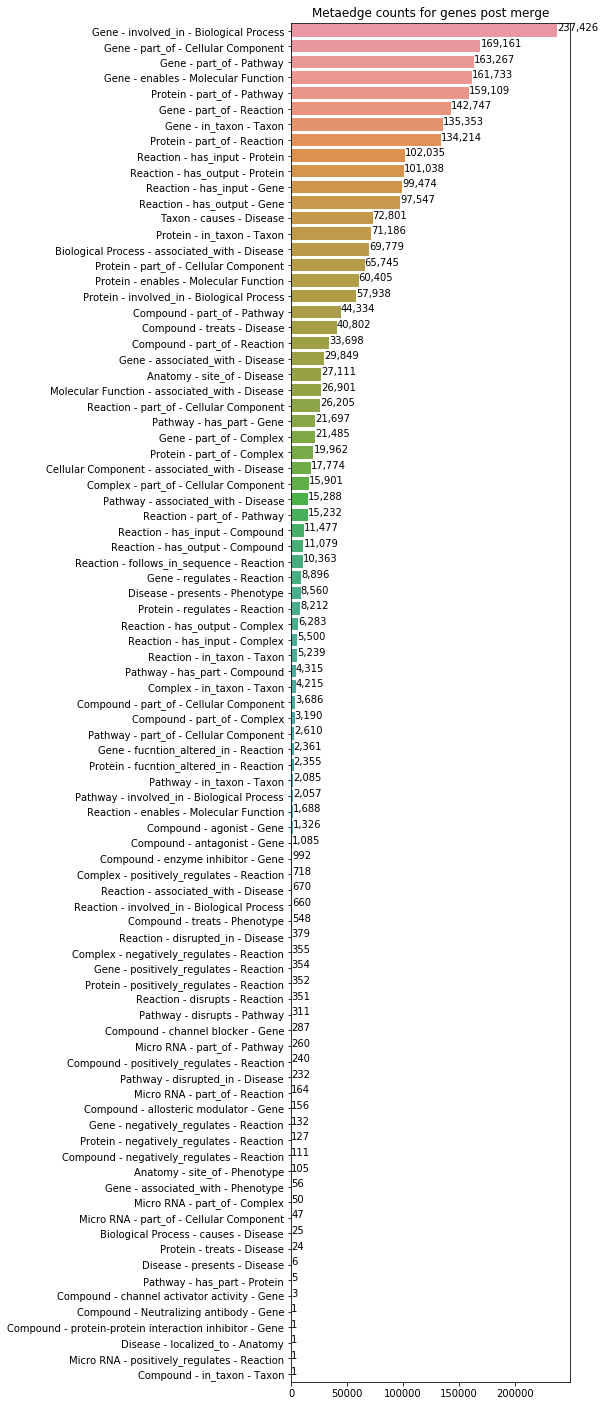

In [77]:
plt.figure(figsize=(5, 25))
count_plot_h(me.value_counts())
plt.title('Metaedge counts for genes post merge');